# Test Diffusion Models in Simple 2D-Data

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions import Categorical
import math

from sklearn import datasets

In [86]:
device = "cpu"

In [87]:
#X, _ = datasets.make_moons(n_samples=1000, noise=0.01)
X, _ = datasets.make_blobs(n_samples=1000, centers=5)
#X = torch.randn(1000,2)

tensor([[ 8.6243, -4.1807],
        [-6.9457,  2.8815],
        [-9.8330, -3.2227],
        ...,
        [-8.0633,  3.8834],
        [ 5.1072,  3.1100],
        [-6.1414,  3.9488]])

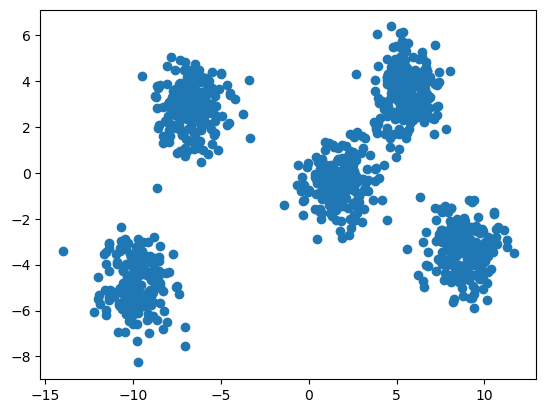

In [88]:
X = torch.tensor(X, dtype=torch.float32) #+ torch.Tensor([20., 20.])
plt.scatter(X[:,0], X[:,1])
X.to(device)

In [89]:
def linear_beta_schedule(timesteps):
    alpha_start = 0.0001
    alpha_end = 0.4
    return torch.linspace(alpha_start, alpha_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.7
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


In [90]:
timesteps = 50

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps).to(device)
#betas = quadratic_beta_schedule(timesteps=timesteps)
betas[0] = 0
# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sigma_q = (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)*betas

factor = (1./sigma_q)*alphas_cumprod_prev * \
        torch.pow(1. - alphas,2)/torch.pow(1.-alphas_cumprod, 2)


In [91]:
factor[1] = factor[2]
m = Categorical(factor[1:-1])
m.sample((10,))+1

tensor([ 2,  2,  2,  2,  2,  2,  3, 16,  3,  2])

In [92]:
alphas_cumprod

tensor([1.0000e+00, 9.9722e-01, 9.9176e-01, 9.8368e-01, 9.7302e-01, 9.5987e-01,
        9.4431e-01, 9.2648e-01, 9.0649e-01, 8.8450e-01, 8.6068e-01, 8.3518e-01,
        8.0820e-01, 7.7992e-01, 7.5054e-01, 7.2025e-01, 6.8925e-01, 6.5773e-01,
        6.2589e-01, 5.9391e-01, 5.6197e-01, 5.3024e-01, 4.9888e-01, 4.6803e-01,
        4.3784e-01, 4.0842e-01, 3.7988e-01, 3.5231e-01, 3.2580e-01, 3.0041e-01,
        2.7619e-01, 2.5318e-01, 2.3141e-01, 2.1090e-01, 1.9163e-01, 1.7361e-01,
        1.5682e-01, 1.4123e-01, 1.2681e-01, 1.1353e-01, 1.0133e-01, 9.0166e-02,
        7.9993e-02, 7.0754e-02, 6.2391e-02, 5.4850e-02, 4.8072e-02, 4.2004e-02,
        3.6588e-02, 3.1773e-02, 2.7506e-02, 2.3738e-02, 2.0423e-02, 1.7516e-02,
        1.4975e-02, 1.2763e-02, 1.0844e-02, 9.1838e-03, 7.7533e-03, 6.5248e-03,
        5.4734e-03, 4.5768e-03, 3.8147e-03, 3.1693e-03, 2.6246e-03, 2.1665e-03,
        1.7825e-03, 1.4618e-03, 1.1949e-03, 9.7347e-04, 7.9048e-04, 6.3977e-04,
        5.1608e-04, 4.1492e-04, 3.3247e-

In [93]:
def q_sample(x_start, t):
          
    noise = torch.randn_like(x_start).to(device)

    return torch.sqrt(alphas_cumprod)[t].unsqueeze(dim=1) * x_start + \
        torch.sqrt(1.-alphas_cumprod)[t].unsqueeze(dim=1) * noise

In [94]:
samples = q_sample(X[0:3],[1,1,19])
samples

tensor([[ 8.6313, -4.1849],
        [-6.9111,  2.8457],
        [-7.4563, -3.0832]])

In [95]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [96]:
pdim = 32
pe = PositionalEncoding(pdim, 0)
emb = pe.forward(torch.zeros(1, timesteps, pdim)).squeeze(0)

In [97]:
class SimpleDifussion(nn.Module):
   def __init__(self, pdim, x_dim, h_dim1, h_dim2):
      super(SimpleDifussion, self).__init__() 

      self.fc1 = nn.Linear(x_dim + pdim, h_dim1)
      self.fc2 = nn.Linear(h_dim1, h_dim2)
      self.fc3 = nn.Linear(h_dim2, x_dim)
      
   def forward(self, x):
        h = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        return self.fc3(h)

In [98]:
def p_losses(denoise_model, x_start, t):
    noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start, t)
    time_emb = emb[t]
    predicted_x0 = denoise_model(torch.cat((x_noisy, time_emb),1))
    #loss = F.mse_loss(predicted_x0, x_start)
    loss = F.mse_loss(predicted_x0, x_start)
    # did not include factor
    return loss

## Train Model

In [99]:
from torch.optim import Adam
from torch.utils.data import DataLoader


model = SimpleDifussion(pdim, 2, 64, 32)
model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(X, batch_size=64, shuffle=True)

In [100]:
epochs = 2000

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(1, timesteps, (batch.size(0),), device=device)
        #t = m.sample((batch.size(0),))
        loss = p_losses(model, batch, t)

        if step % 100 == 0:
            print(f'Loss:{loss.item()}')

        if epoch == 200:
            print("Debug")
        
        loss.backward()
        optimizer.step()

Loss:28.347387313842773
Loss:30.675539016723633
Loss:28.95359230041504
Loss:30.258119583129883
Loss:21.189842224121094
Loss:22.19509506225586
Loss:26.680871963500977
Loss:24.15485191345215
Loss:21.840707778930664
Loss:18.58049964904785
Loss:19.856433868408203
Loss:18.20481300354004
Loss:22.117387771606445
Loss:26.316774368286133
Loss:20.870452880859375
Loss:22.40271759033203
Loss:21.767715454101562
Loss:27.45705223083496
Loss:19.923412322998047
Loss:22.042062759399414
Loss:22.150604248046875
Loss:24.902427673339844
Loss:20.51652717590332
Loss:23.138147354125977
Loss:23.40522003173828
Loss:18.176406860351562
Loss:23.395612716674805
Loss:18.79034423828125
Loss:18.427356719970703
Loss:19.85414695739746
Loss:18.4237003326416
Loss:22.649625778198242
Loss:23.562366485595703
Loss:23.43419075012207
Loss:22.005338668823242
Loss:22.67932891845703
Loss:22.7742862701416
Loss:24.137054443359375
Loss:19.518320083618164
Loss:19.821680068969727
Loss:21.624073028564453
Loss:22.58252716064453
Loss:21.55

## Generate Samples

In [101]:
@torch.no_grad()
def p_sample(model, n_samples, t0):
    samples = torch.randn((n_samples,2))
    for t in reversed(range(t0+1, timesteps)):
        # Generate in reverse order samples
        ts = torch.ones(n_samples, dtype=torch.int)*t
        time_emb = emb[ts]
        x0p = model(torch.cat((samples, time_emb),1))
        mu_t = (torch.sqrt(alphas[t])*(1.-alphas_cumprod_prev[t])*samples \
             + torch.sqrt(alphas_cumprod_prev[t])*betas[t]*x0p) \
              / (1-alphas_cumprod[t])
        #mu_t = (1/torch.sqrt(alphas[t]))*(samples - \
        #    (betas[t]/torch.sqrt(1.-alphas_cumprod[t]))*x0p)
        if t==1:
            samples = mu_t
        else:
            noise = torch.randn_like(samples)
            samples = mu_t + torch.sqrt(sigma_q[t])*noise  
    
    return samples

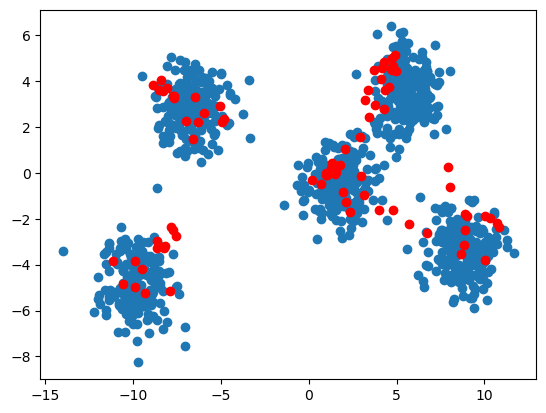

In [102]:
samples = p_sample(model, 80, 0)
plt.scatter(X[:,0], X[:,1])
plt.scatter(samples[:,0], samples[:,1], c = 'r')
plt.show()

In [103]:
@torch.no_grad()
def compare_posterior_p(model, n_samples, t):

    #Generate q samples at time t
    ts = torch.ones(n_samples, dtype=torch.int)*t
    indx = torch.randint(0, X.size(0), (n_samples,), device=device)
    x_start = X[indx]
    qsamples = q_sample(x_start, ts)

    #Generate p samples at time t

    psamples = p_sample(model, n_samples,t)

    plt.scatter(qsamples[:,0], qsamples[:,1])
    plt.scatter(psamples[:,0], psamples[:,1], c = 'r')
    plt.show()

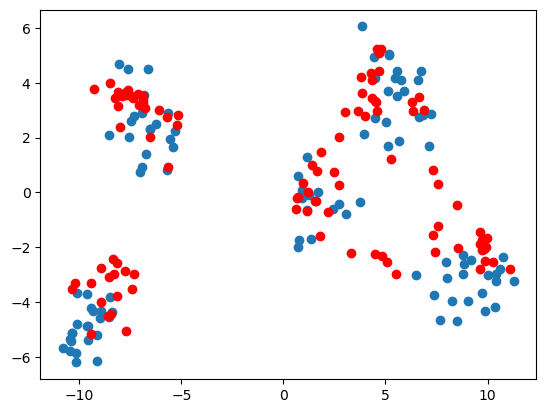

In [104]:
compare_posterior_p(model, 100, 0)